INFO:absl:Load dataset info from ../../../../../local_data/tfds/tf_flowers/3.0.1
INFO:absl:Fields info.[splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset tf_flowers (../../../../../local_data/tfds/tf_flowers/3.0.1)
INFO:absl:Constructing tf.data.Dataset tf_flowers for split ['train[:40%]', 'train[40%:50%]'], from ../../../../../local_data/tfds/tf_flowers/3.0.1
2025-07-07 14:50:32.950784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Number of training samples: 1468
Number of validation samples: 367
train_ds <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


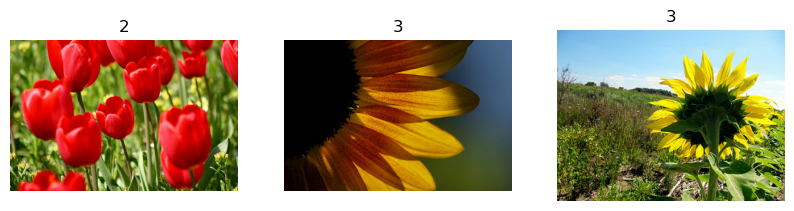

In [ ]:
# based on https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_2_keras_xfer_cv.ipynb

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import logging, os
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
# logging.basicConfig(level=logging.DEBUG)

BASE_PATH = "../../../../../local_data/pratice/tfds"
DATA_PATH = "../../../../../local_data/tfds/"
OUTPUT_PATH = BASE_PATH+"mnist_transfer_fit_jh/"
os.system("mkdir -p " + OUTPUT_PATH)

(train_ds, validation_ds), metadata= tfds.load(
    # 'mnist',
    # 'cifar10',
    'tf_flowers',
    # 'cats_vs_dogs',
    data_dir=DATA_PATH,
    split=["train[:40%]", "train[40%:50%]"],
    with_info=True,
    as_supervised=True, 
)# Include labels

num_train = tf.data.experimental.cardinality(train_ds)
num_test = tf.data.experimental.cardinality(validation_ds)
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")
print("train_ds",train_ds)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(3)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [17]:
size = (150, 150)

# train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size)/ 255.0, y))
# validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size)/ 255.0, y))
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [18]:
num_train = tf.data.experimental.cardinality(train_ds)
num_test = tf.data.experimental.cardinality(validation_ds)
print(f"Number of training samples: {num_train}")
print(f"Number of validation samples: {num_test}")
print("train_ds",train_ds)

Number of training samples: 1468
Number of validation samples: 367
train_ds <_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [19]:
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache() \
.batch(batch_size).prefetch(buffer_size=10)

In [20]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [21]:
base_model = keras.applications.Xception(
    weights="imagenet", # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
) # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs) # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers.
# We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning,
# so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                           

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
 5/46 [==>...........................] - ETA: 28s - loss: -0.5289 - binary_accuracy: 0.1813

KeyboardInterrupt: 

In [ ]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

# model.fit(
#     train_ds,
#     epochs=1,
#     validation_data=validation_ds,
# )